In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

import os
from tqdm import tqdm


%matplotlib inline
# check cuda availability
torch.cuda.is_available()
mps_device = torch.device("mps")



In [9]:
IMG_DIR = '/Volumes/TaoElements/csci1470-finalproject/spectrogram_images'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 7
NUM_EPOCHS = 10
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [10]:
# Randomly select 1 spectrogram from each category for plotting
sample_files = ['136_Hip_hop_music.jpg', 
                 '6627_Pop_music.jpg',
                 '44153_Vocal.jpg',
                 '3400_Rhythm_blues.jpg',
                 '12908_Reggae.jpg',
                 '22013_Rock_music.jpg',
                 '21163_Techno.jpg']

label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }
one_hot = OneHotEncoder(categories=[range(NUM_CLASSES)])

all_files = os.listdir(IMG_DIR)

# Get class weights
label_array = []
for file_ in all_files:
    vals = file_[:-4].split('_')
    label_array.append(label_dict[vals[1]])
    
cl_weight = compute_class_weight(class_weight = 'balanced', 
                                 classes = np.unique(label_array), 
                                 y = label_array)

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(all_files, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.1
                                                                     )

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5
                                                                 )

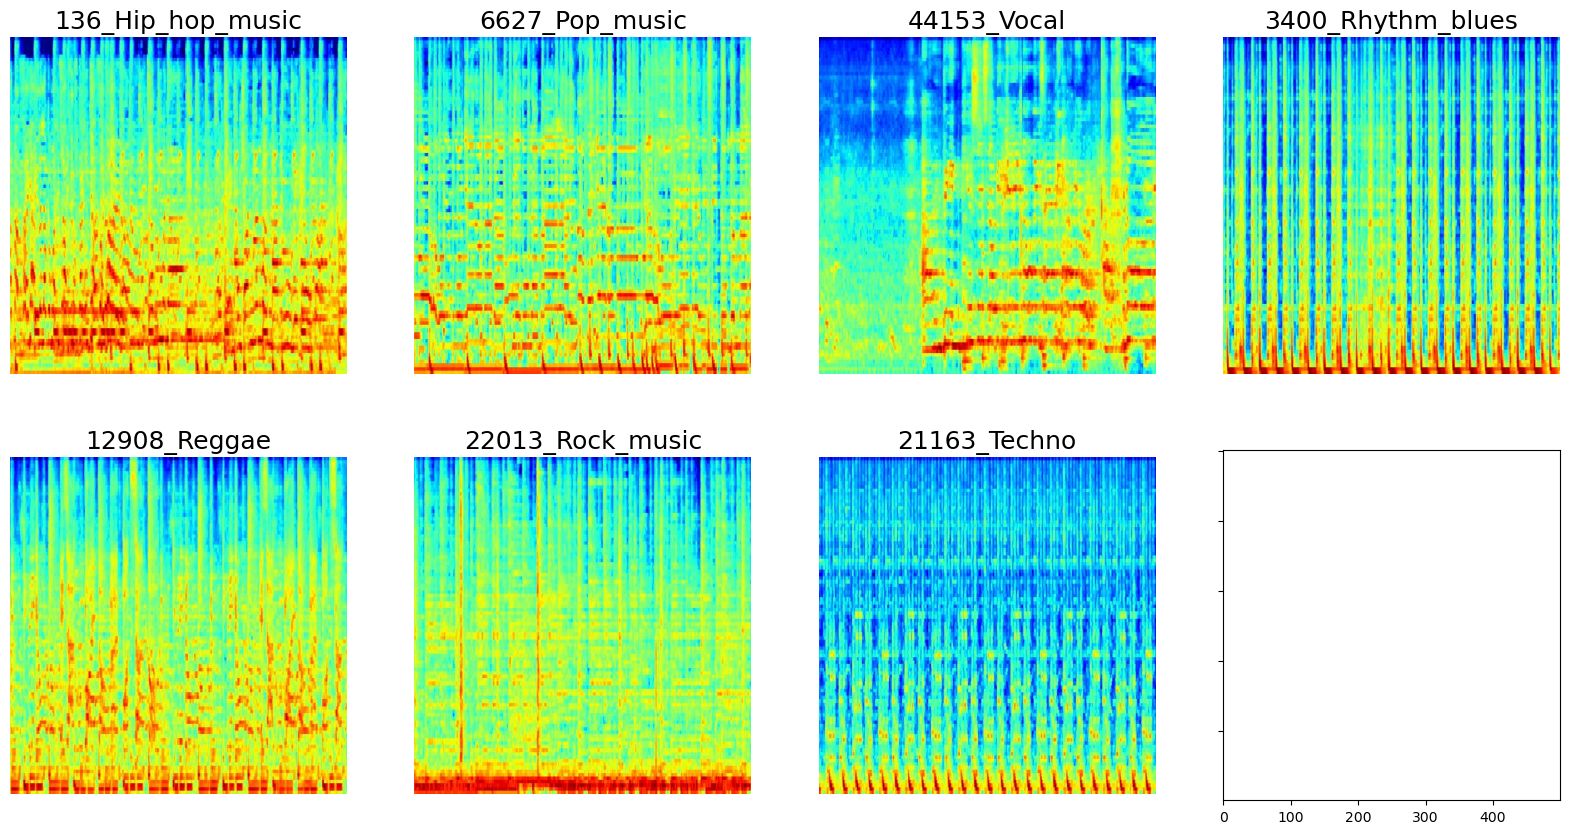

In [14]:
f, axarr = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0),(0,1),(0,2),(0,3), 
               (1,0),(1,1),(1,2) ]

for i, file_ in enumerate(sample_files):
    im = Image.open(IMG_DIR + '/' + file_)

    # im = im.resize((IMG_WIDTH, IMG_HEIGHT), resample = Image.ANTIALIAS)
    axarr[coordinates[i]].imshow(np.asarray(im))
    axarr[coordinates[i]].axis('off')
    axarr[coordinates[i]].set_title(file_[:-4], fontsize=18)


In [61]:
conv_base = models.vgg16(weights = "IMAGENET1K_V1", progress=True)

in_features = conv_base.classifier[0].in_features

conv_base.classifier = torch.nn.Identity()

conv_base.eval()

# summary(conv_base)
print(conv_base.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [38]:
class L2RegularizedLinear(nn.Module):
  def __init__(self, in_features, out_features, l2_lambda):
    super(L2RegularizedLinear, self).__init__()
    self.linear = nn.Linear(in_features, out_features)
    self.l2_lambda = l2_lambda
  
  def forward(self, x):
    output = self.linear(x)
    l2_reg = torch.norm(self.linear.weight) * self.l2_lambda
    output += l2_reg
    return output


model = nn.Sequential(
  conv_base,
  nn.Flatten(),
  L2RegularizedLinear(in_features, 512, L2_LAMBDA),
  nn.Dropout(p=0.3),
  nn.ReLU(),
  nn.Linear(512, NUM_CLASSES),
  nn.Softmax()
)

In [39]:
#Set the convolution base to not be trainable
for param in conv_base.parameters():
    param.requires_grad = False
summary(model)

Layer (type:depth-idx)                   Param #
├─VGG: 1-1                               --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  (1,792)
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  (36,928)
|    |    └─ReLU: 3-4                    --
|    |    └─MaxPool2d: 3-5               --
|    |    └─Conv2d: 3-6                  (73,856)
|    |    └─ReLU: 3-7                    --
|    |    └─Conv2d: 3-8                  (147,584)
|    |    └─ReLU: 3-9                    --
|    |    └─MaxPool2d: 3-10              --
|    |    └─Conv2d: 3-11                 (295,168)
|    |    └─ReLU: 3-12                   --
|    |    └─Conv2d: 3-13                 (590,080)
|    |    └─ReLU: 3-14                   --
|    |    └─Conv2d: 3-15                 (590,080)
|    |    └─ReLU: 3-16                   --
|    |    └─MaxPool2d: 3-17              --
|    |    └─Conv2d: 3-18                 (1,180,160)
|    |    └─ReLU:

Layer (type:depth-idx)                   Param #
├─VGG: 1-1                               --
|    └─Sequential: 2-1                   --
|    |    └─Conv2d: 3-1                  (1,792)
|    |    └─ReLU: 3-2                    --
|    |    └─Conv2d: 3-3                  (36,928)
|    |    └─ReLU: 3-4                    --
|    |    └─MaxPool2d: 3-5               --
|    |    └─Conv2d: 3-6                  (73,856)
|    |    └─ReLU: 3-7                    --
|    |    └─Conv2d: 3-8                  (147,584)
|    |    └─ReLU: 3-9                    --
|    |    └─MaxPool2d: 3-10              --
|    |    └─Conv2d: 3-11                 (295,168)
|    |    └─ReLU: 3-12                   --
|    |    └─Conv2d: 3-13                 (590,080)
|    |    └─ReLU: 3-14                   --
|    |    └─Conv2d: 3-15                 (590,080)
|    |    └─ReLU: 3-16                   --
|    |    └─MaxPool2d: 3-17              --
|    |    └─Conv2d: 3-18                 (1,180,160)
|    |    └─ReLU:

#### Training VGG16

In [59]:
# load images, prepare labels, and normalize 
specto_dir = '/Volumes/TaoElements/csci1470-finalproject/spectrogram_images/'
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(specto_dir + file_)
        im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.Resampling.LANCZOS)
        img_array.append(np.array(im))

        vals = file_[:-4].split('_')
        idx_array.append(vals[0])
        label_array.append([label_dict[vals[1]]])

    label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB
    
    return img_array, np.array(label_array), np.array(idx_array)

In [50]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

            # Convert numpy arrays to PyTorch tensors
            batch_img_array = torch.tensor(batch_img_array, dtype=torch.float32)
            batch_label_array = torch.tensor(batch_label_array, dtype=torch.float32)
            

            yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [74]:
# set training optimizer, loss, and metrics
optimizer = optim.Adam(model.parameters(), lr=1e-5)
loss_function = torch.nn.functional.cross_entropy

def categorical_accuracy(output, target):
    predicted = torch.argmax(output, dim=0)
    # print(predicted.shape, target.shape)
    correct = (predicted == target).float()
    return correct.sum()


In [75]:
# Calculate number of steps per epoch
STEPS_PER_EPOCH = len(train_files) // BATCH_SIZE
VAL_STEPS = len(val_files) // BATCH_SIZE

# Initialize lists to store training and validation losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Training loop
for epoch in range(NUM_EPOCHS):
    # Training
    model.train()  # Set the model to train mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(batch_generator(train_files, BATCH_SIZE)), total=STEPS_PER_EPOCH):
        # Permute the inputs to [N, C, H, W] from [N, H, W, C]
        inputs = inputs.permute(0, 3, 1, 2)
        # inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = loss_function(outputs, targets)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        train_loss += loss.item()
        # aggregate total number 
        correct_train += categorical_accuracy(outputs, targets)
        total_train += targets.size(0)
        # _, predicted = outputs.max(1)
        # correct_train += predicted.eq(targets).sum().item()

    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / STEPS_PER_EPOCH
    train_accuracy = 100. * correct_train / total_train

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(batch_generator(val_files, BATCH_SIZE)), total=VAL_STEPS):
            outputs = model(inputs)  # Forward pass
            loss = loss_function(outputs, targets)  # Calculate the loss
            val_loss += loss.item()
            # _, predicted = outputs.max(1)
            total_val += targets.size(0)
            correct_val += categorical_accuracy(outputs, targets)

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / VAL_STEPS
    val_accuracy = 100. * correct_val / total_val

    # Print training and validation metrics
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}, '
          f'Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    # Save the model checkpoint
    cur_dir = os.getcwd()
    root_dir = os.path.dirname(cur_dir)
    ckpt_dir = os.path.join(root_dir, f'saved_models/fine_tuning_epoch_{epoch + 1}_{val_accuracy:.4f}.pt')
    torch.save(model.state_dict(), ckpt_dir)

    # Append metrics to lists for plotting later if needed
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/990 [00:00<?, ?it/s]/Users/macuser/miniconda3/envs/csci1470/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 1/990 [00:03<1:04:53,  3.94s/it]

torch.Size([7]) torch.Size([32, 7])


/Users/macuser/miniconda3/envs/csci1470/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 2/990 [00:07<1:02:16,  3.78s/it]

torch.Size([7]) torch.Size([32, 7])


/Users/macuser/miniconda3/envs/csci1470/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 3/990 [00:11<1:01:51,  3.76s/it]

torch.Size([7]) torch.Size([32, 7])


/Users/macuser/miniconda3/envs/csci1470/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  0%|          | 4/990 [00:14<1:00:55,  3.71s/it]

torch.Size([7]) torch.Size([32, 7])


/Users/macuser/miniconda3/envs/csci1470/lib/python3.10/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
  1%|          | 5/990 [00:18<1:00:43,  3.70s/it]

torch.Size([7]) torch.Size([32, 7])


  1%|          | 5/990 [00:21<1:11:54,  4.38s/it]


KeyboardInterrupt: 